# <center>Social Network Graph Link Prediction - Facebook Case Study</center>

### Problem Statement

Given a directed social graph, predict missing links to recommend users (Link prediction in the graph).

### Data Overview

The dataset is taken from Facebook's recruiting challenge on Kaggle - https://www.kaggle.com/c/FacebookRecruiting <br>
The dataset contains two columns source and destination eac edge in the graph.
- source_node (int64)
- destination_node (int64)

### Mapping the Problem into a Supervised Learning Problem

Generated training samples of good and bad links from the given directed graph and for each link got some features like no. of followers, are they followed back, page rank, Katz score, Adar index, some svd features of adj matrix, some weight features, etc. and trained ml model based on these features to predict link.

### Business Objectives and Constraints

- No low-latency requirement.
- Probability of prediction is useful to recommend the highest probability links.

### Performance Metrics for Supervised Learning

- Both precision and recall are important so F1-score is a good choice.
- Confusion matrix.

In [1]:
# Importing necessary libraries
import os
import csv
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds, eigs
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from tqdm.notebook import tqdm

import networkx as nx
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
# Loading the training data
df = pd.read_csv('data/train.csv')


In [3]:
# Checking the shape of the data
df.shape


(9437519, 2)

In [4]:
# Checking how the data looks like
df.head()


,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [5]:
# Checking the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB


In [6]:
# Checking for missing values
df.isna().sum()


source_node         0
destination_node    0
dtype: int64

- There are no missing values

In [7]:
# Removing the header from the train data and saving it
df.to_csv('train_without_header.csv', index=False, header=False)


In [8]:
del df


In [9]:
# Constructing graph using the edges present in the train data
graph = nx.read_edgelist(path='train_without_header.csv', 
                        delimiter=',', 
                        create_using=nx.DiGraph(), 
                        nodetype=int)


In [10]:
# Looking into the info of graph
print(graph)


DiGraph with 1862220 nodes and 9437519 edges


DiGraph with 122 nodes and 100 edges


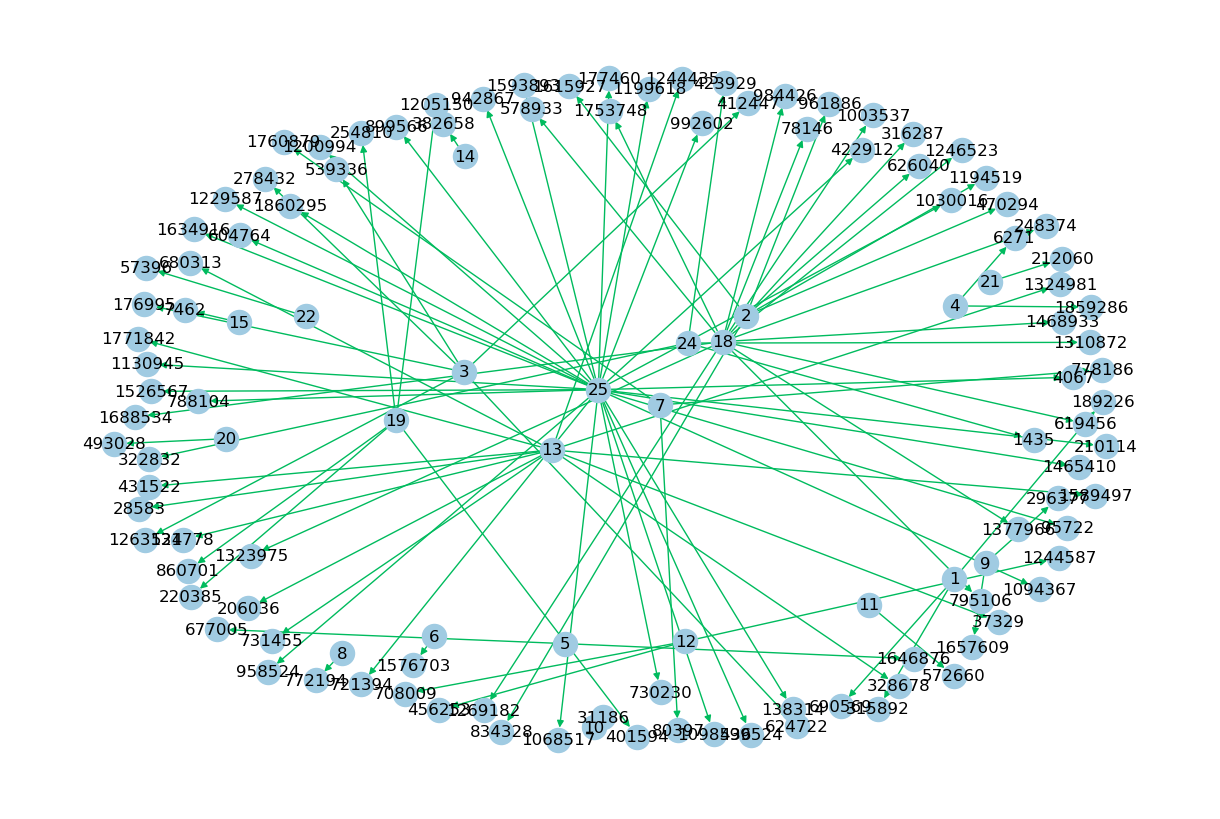

In [11]:
# Displaying a subgraph

# Reading the first 100 rows of the data and saving it
pd.read_csv('data/train.csv', nrows=100).to_csv('train_without_header_sample.csv', index=False, header=False)
subgraph = nx.read_edgelist(path='train_without_header_sample.csv', 
                        delimiter=',', 
                        create_using=nx.DiGraph(), 
                        nodetype=int)
print(subgraph)

pos = nx.spring_layout(subgraph)

plt.figure(figsize=(12,8))
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#00bb5e', width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()


## Exploratory Data Analysis


In [12]:
# Number of unique persons in the graph
print(f"The number of unique persons: {len(graph.nodes())}")


The number of unique persons: 1862220


#### Number of followers of each person

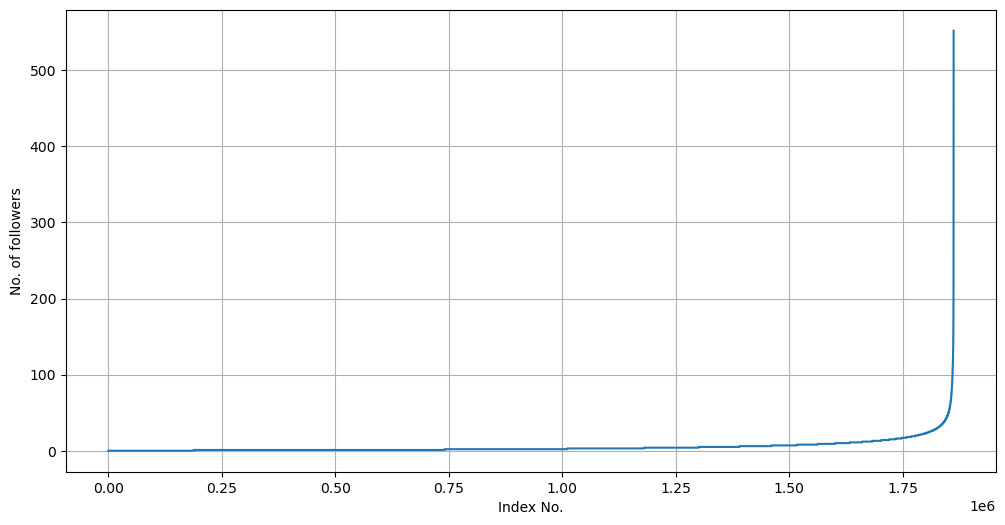

In [13]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(indegree_dist)
plt.xlabel('Index No.')
plt.ylabel('No. of followers')
plt.show()


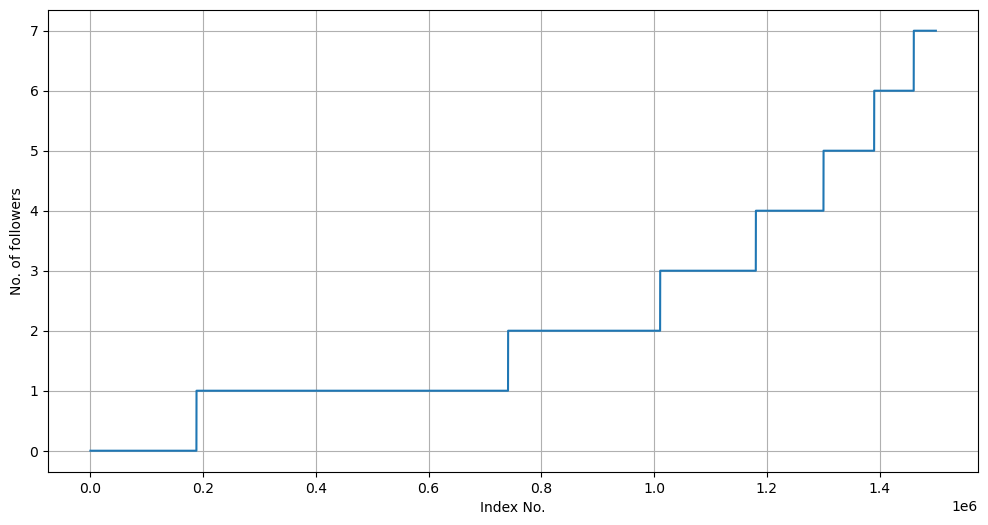

In [14]:
# Let's zoon in the plot
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No.')
plt.ylabel('No. of followers')
plt.show()


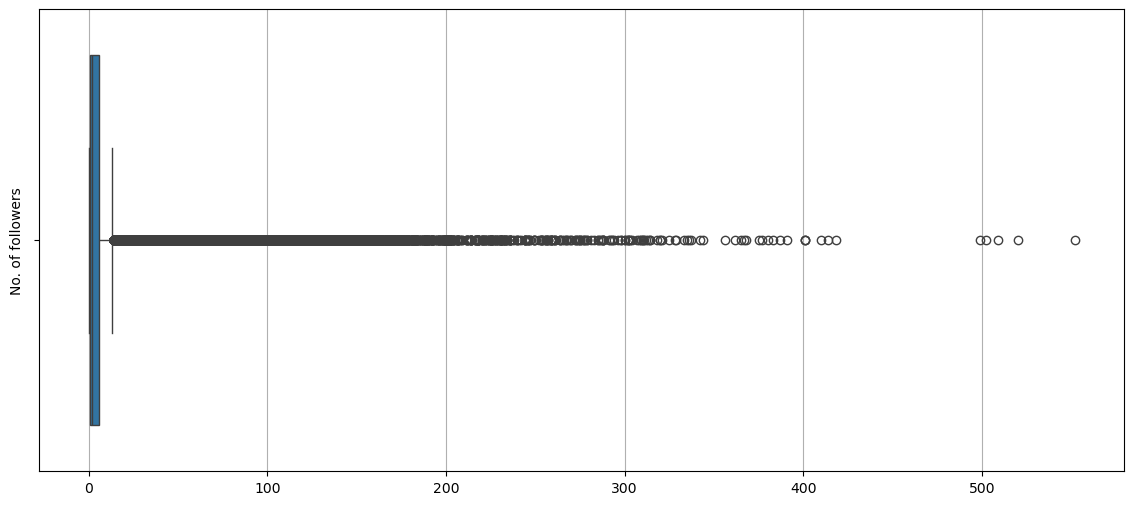

In [15]:
# Let's plot a boxplot for the number of followers of the users
plt.figure(figsize=(14,6))
plt.grid()
sns.boxplot(x=indegree_dist)
plt.ylabel('No. of followers')
plt.show()


In [16]:
# Let's look at the 0-100 percentile
for i in range(10,110,10):
    print(f"{i} percentile value is {np.percentile(indegree_dist, i)}")
    

10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 552.0


In [17]:
# Let's zoom in between 90-100 percentile
for i in range(90,101):
    print(f"{i} percentile value is {np.percentile(indegree_dist, i)}")
    

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [18]:
# Let's zoom in between 99-100 percentile
for i in np.linspace(99,100,11):
    print(f"{i} percentile value is {np.percentile(indegree_dist, i)}")
    

99.0 percentile value is 40.0
99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


<b>Observations</b>
- 50% of the users have less than or equal to 2 followers.
- 90% of the users have less than or equal to 12 followers.
- 99% of the users have less than or equal to 40 followers.

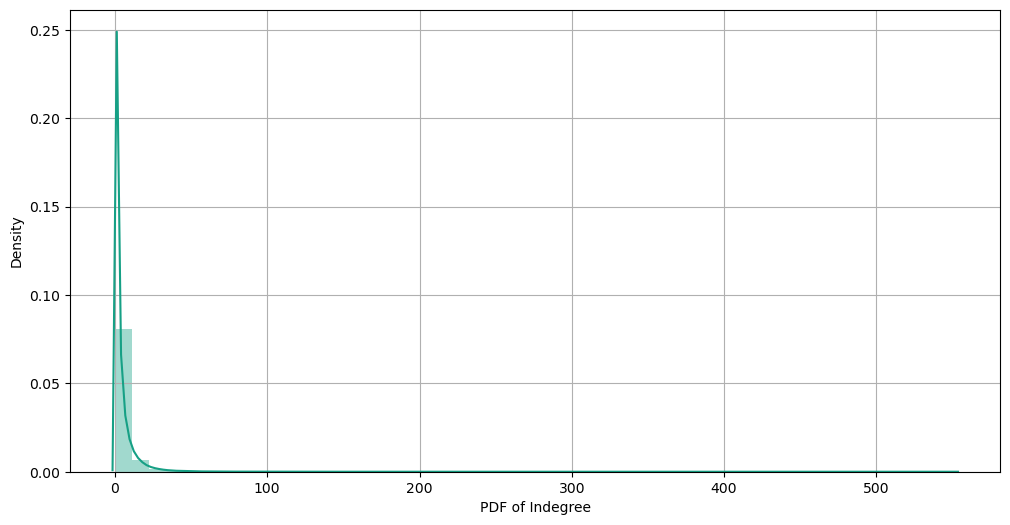

In [19]:
plt.figure(figsize=(12,6))
plt.grid()
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
plt.show()


#### Number of users each person is following

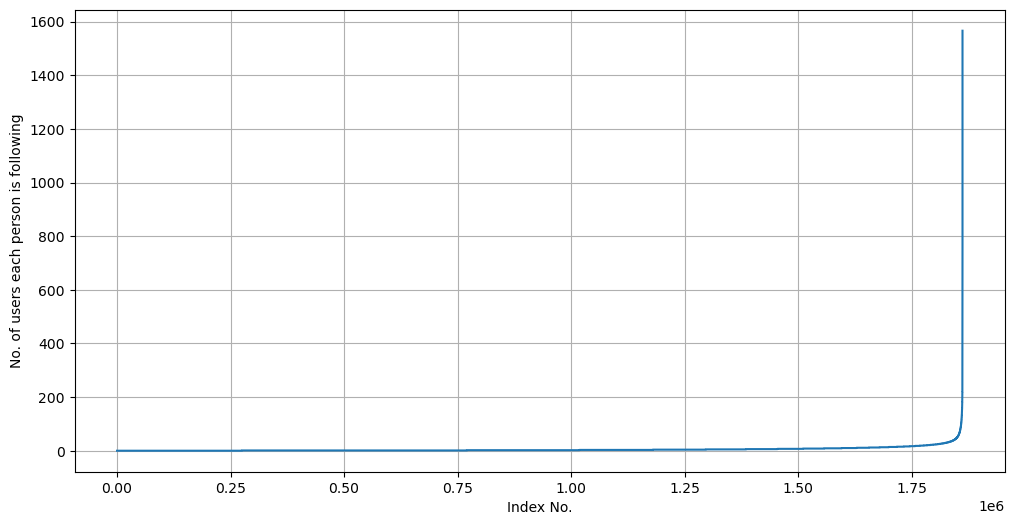

In [20]:
outdegree_dist = list(dict(graph.out_degree()).values())
outdegree_dist.sort()

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(outdegree_dist)
plt.xlabel('Index No.')
plt.ylabel('No. of users each person is following')
plt.show()


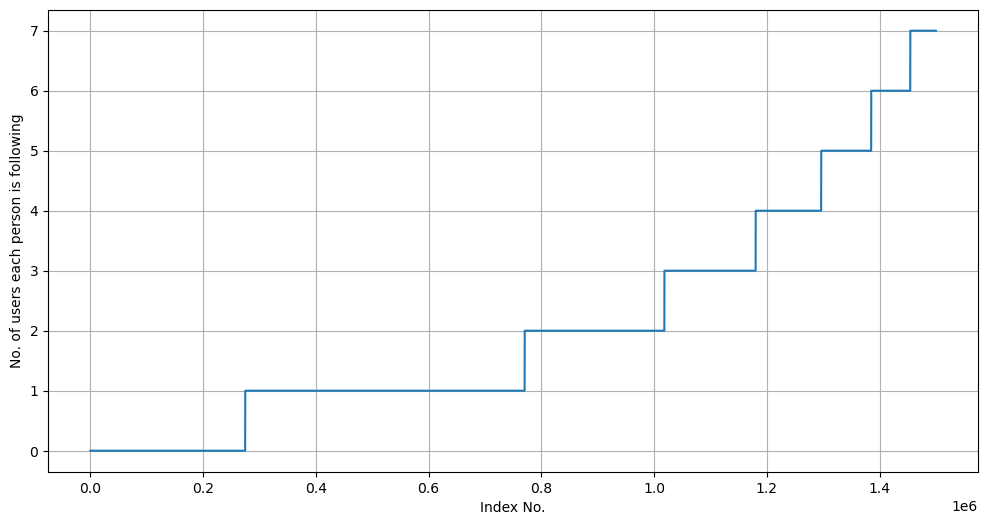

In [21]:
# Let's zoon in the plot
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No.')
plt.ylabel('No. of users each person is following')
plt.show()


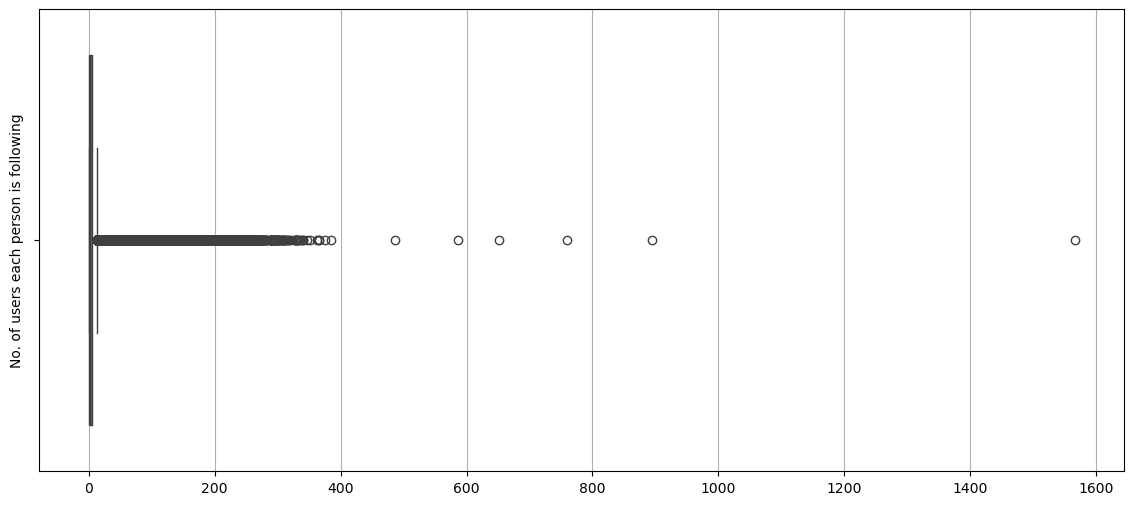

In [22]:
# Let's plot a boxplot for the number of users each person is following
plt.figure(figsize=(14,6))
plt.grid()
sns.boxplot(x=outdegree_dist)
plt.ylabel('No. of users each person is following')
plt.show()


In [23]:
# Let's look at the 0-100 percentile
for i in range(10,110,10):
    print(f"{i} percentile value is {np.percentile(outdegree_dist, i)}")
    

10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 1.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 1566.0


In [24]:
# Let's zoom in between 90-100 percentile
for i in range(90,101):
    print(f"{i} percentile value is {np.percentile(outdegree_dist, i)}")
    

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [25]:
# Let's zoom in between 99-100 percentile
for i in np.linspace(99,100,11):
    print(f"{i} percentile value is {np.percentile(outdegree_dist, i)}")
    

99.0 percentile value is 40.0
99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


<b>Observations</b>
- 50% of the people are following less than or equal to 2 users.
- 90% of the people are following less than or equal to 12 users.
- 99% of the people are following less than or equal to 40 users.

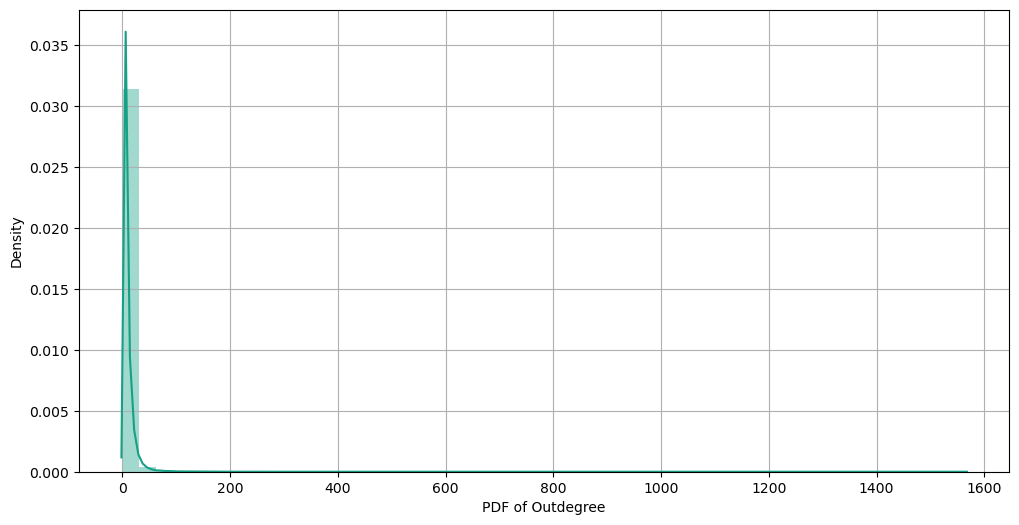

In [26]:
plt.figure(figsize=(12,6))
plt.grid()
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
plt.show()


In [27]:
print(f"Number of users who are not following anyone: {sum(np.array(outdegree_dist)==0)} ~ {round(sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist), 2)}%")


Number of users who are not following anyone: 274512 ~ 14.74%


In [28]:
print(f"Number of users who have zero followers: {sum(np.array(indegree_dist)==0)} ~ {round(sum(np.array(indegree_dist)==0)*100/len(indegree_dist), 2)}%")


Number of users who have zero followers: 188043 ~ 10.1%


In [29]:
count = 0
for node in graph.nodes():
    if len(list(graph.predecessors(node)))==0:
        if len(list(graph.successors(node)))==0:
            count += 1

print(f"Number of users who are not following anyone and have zero followers are: {count}")


Number of users who are not following anyone and have zero followers are: 0


#### Both Followers + Following

In [30]:
dict_in = dict(graph.in_degree())
dict_out = dict(graph.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))
in_out_degree_sort = sorted(in_out_degree)


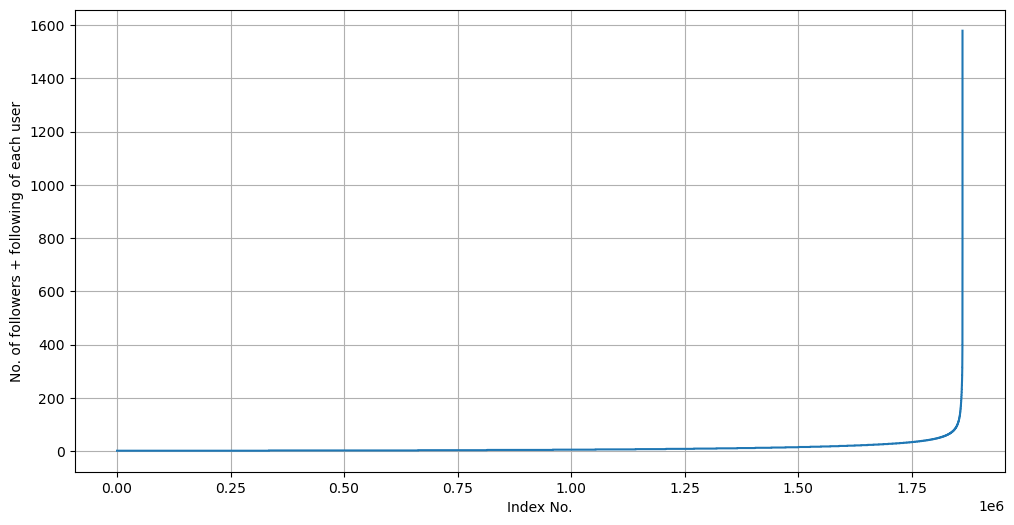

In [31]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(in_out_degree_sort)
plt.xlabel('Index No.')
plt.ylabel('No. of followers + following of each user')
plt.show()


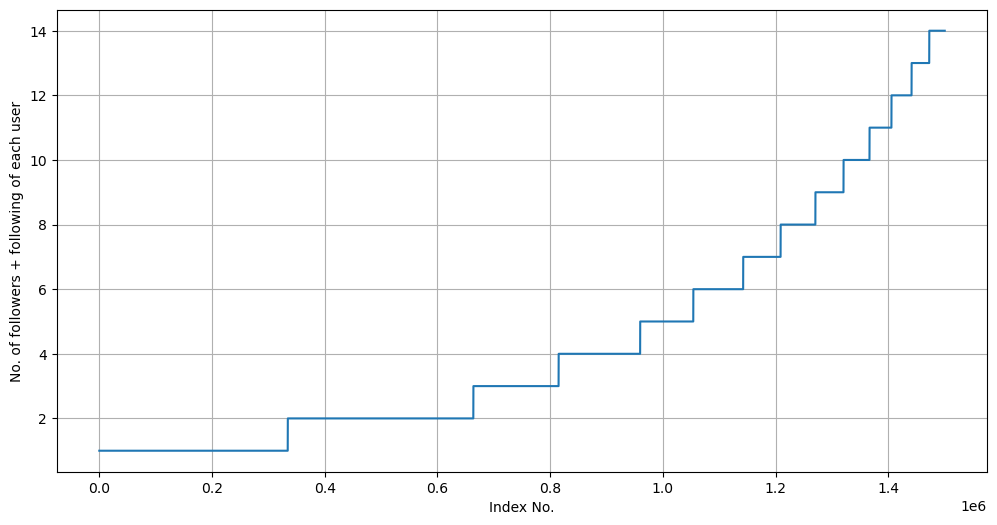

In [32]:
# Let's zoon in the plot
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No.')
plt.ylabel('No. of followers + following of each user')
plt.show()


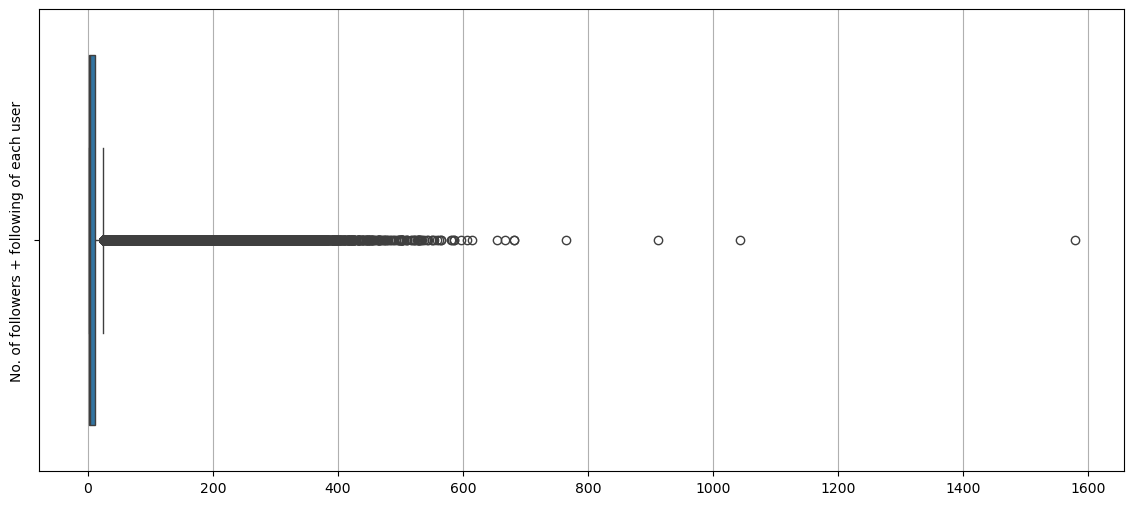

In [33]:
# Let's plot a boxplot for the number of followers + following of each user
plt.figure(figsize=(14,6))
plt.grid()
sns.boxplot(x=in_out_degree_sort)
plt.ylabel('No. of followers + following of each user')
plt.show()


In [34]:
# Let's look at the 0-100 percentile
for i in range(10,110,10):
    print(f"{i} percentile value is {np.percentile(in_out_degree_sort, i)}")
    

10 percentile value is 1.0
20 percentile value is 2.0
30 percentile value is 2.0
40 percentile value is 3.0
50 percentile value is 4.0
60 percentile value is 6.0
70 percentile value is 9.0
80 percentile value is 14.0
90 percentile value is 24.0
100 percentile value is 1579.0


In [35]:
# Let's zoom in between 90-100 percentile
for i in range(90,101):
    print(f"{i} percentile value is {np.percentile(in_out_degree_sort, i)}")
    

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [36]:
# Let's zoom in between 99-100 percentile
for i in np.linspace(99,100,11):
    print(f"{i} percentile value is {np.percentile(in_out_degree_sort, i)}")
    

99.0 percentile value is 79.0
99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


<b>Observations</b>
- 50% of the people have less than or equal to 4 followers + following.
- 90% of the people have less than or equal to 24 followers + following.
- 99% of the people have less than or equal to 79 followers + following.

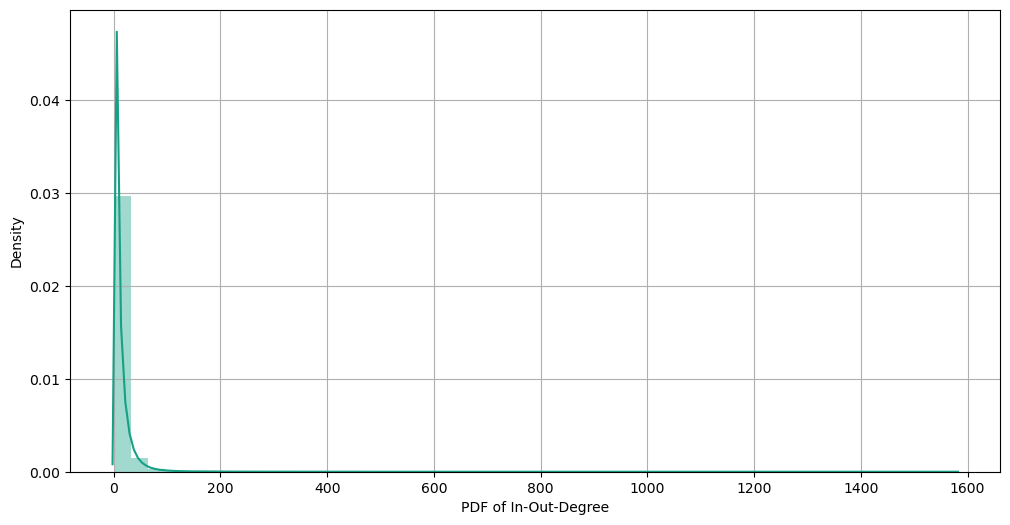

In [37]:
plt.figure(figsize=(12,6))
plt.grid()
sns.distplot(in_out_degree_sort, color='#16A085')
plt.xlabel('PDF of In-Out-Degree')
plt.show()


In [38]:
print(f"Minimum number of followers + following is: {in_out_degree.min()}")
print(f"Number of users having minimum number of followers + following: {np.sum(in_out_degree==in_out_degree.min())} ~ {round(np.sum(in_out_degree==in_out_degree.min())*100/len(in_out_degree), 2)}%")


Minimum number of followers + following is: 1
Number of users having minimum number of followers + following: 334291 ~ 17.95%


In [39]:
print(f"Maximum number of followers + following is: {in_out_degree.max()}")
print(f"Number of users having maximum number of followers + following: {np.sum(in_out_degree==in_out_degree.max())}")


Maximum number of followers + following is: 1579
Number of users having maximum number of followers + following: 1


In [40]:
print(f"Number of users having followers + following less than 10 are: {np.sum(in_out_degree<10)} ~ {round(np.sum(in_out_degree<10)*100/len(in_out_degree), 2)}%")


Number of users having followers + following less than 10 are: 1320326 ~ 70.9%


In [41]:
print(f"Number of weakly connected components: {len(list(nx.weakly_connected_components(graph)))}")

count = 0
for i in list(nx.weakly_connected_components(graph)):
    if len(i)==2:
        count += 1

print(f"Weakly connected components with 2 nodes: {count}")


Number of weakly connected components: 45558
Weakly connected components with 2 nodes: 32195


## Posing this problem as a Classification Problem

In [42]:
# Creating a missing edges set
graph = csv.reader(open('train_without_header.csv', 'r'))
edges = dict()
for edge in graph:
    edges[(edge[0], edge[1])] = 1

missing_edges = set()
while len(missing_edges) < 9437519:
    a = random.randint(1, 1862220)
    b = random.randint(1, 1862220)
    tmp = edges.get((a,b), -1)
    if tmp==-1 and a!=b:
        try:
            if nx.shortest_path_length(g ,source=a ,target=b) > 2:
                missing_edges.add((a,b))
            else:
                continue
        except:
            missing_edges.add((a,b))
    else:
        continue


In [43]:
len(missing_edges)

9437519

### Splitting the data into train and test set

In [44]:
# Reading total data df
df_pos = pd.read_csv('data/train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges:", df_pos.shape[0])
print("Number of nodes in the graph without edges:", df_neg.shape[0])


Number of nodes in the graph with edges: 9437519
Number of nodes in the graph without edges: 9437519


In [45]:
# Splitting the data into an 80-20 ratio
# Positive links and negative links separately because we need positive training data only for creating graph and for feature generation
X_train_pos,X_test_pos,y_train_pos,y_test_pos = train_test_split(df_pos, np.ones(df_pos.shape[0]), test_size=0.2, random_state=9)
X_train_neg,X_test_neg,y_train_neg,y_test_neg = train_test_split(df_neg, np.zeros(df_neg.shape[0]), test_size=0.2, random_state=9)

print('='*100)
print('Number of nodes in the train data graph with edges:', X_train_pos.shape, y_train_pos.shape)
print('Number of nodes in the train data graph without edges:', X_train_neg.shape, y_train_neg.shape)
print('='*100)
print('Number of nodes in the test data graph with edges:', X_test_pos.shape, y_test_pos.shape)
print('Number of nodes in the test data graph without edges:', X_test_neg.shape, y_test_neg.shape)


Number of nodes in the train data graph with edges: (7550015, 2) (7550015,)
Number of nodes in the train data graph without edges: (7550015, 2) (7550015,)
Number of nodes in the test data graph with edges: (1887504, 2) (1887504,)
Number of nodes in the test data graph without edges: (1887504, 2) (1887504,)


In [46]:
# Removing header and saving the train and test data
X_train_pos.to_csv('train_pos_after_eda.csv', header=False, index=False)
X_test_pos.to_csv('test_pos_after_eda.csv', header=False, index=False)


In [47]:
pd.concat((X_train_pos, X_train_neg), ignore_index=True).to_csv('train_after_eda.csv', header=False, index=False)
pd.concat((X_test_pos, X_test_neg), ignore_index=True).to_csv('test_after_eda.csv', header=False, index=False)
pd.concat((pd.Series(y_train_pos), pd.Series(y_train_neg)), ignore_index=True).to_csv('train_y.csv', header=False, index=False)
pd.concat((pd.Series(y_test_pos), pd.Series(y_test_neg)), ignore_index=True).to_csv('test_y.csv', header=False, index=False)


In [48]:
train_graph = nx.read_edgelist('train_pos_after_eda.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
test_graph = nx.read_edgelist('test_pos_after_eda.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(train_graph)
print(test_graph)

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges


# Feature Engineering

## Similarity Measures

<b>Jaccard Distance</b>
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1itle>
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
  <p>
    \( j = \frac{{\lvert X \cap Y \rvert}}{{\lvert X \cup Y \rvert}} \)
  </p>
</body>
</html>


In [49]:
# For followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a)))==0 | len(set(train_graph.successors(b)))==0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
        return sim
    except:
        return 0



In [50]:
# One test case
print(jaccard_for_followees(273084, 1505602))


0.0


In [51]:
# Testing for node 1635354 which not in graph
print(jaccard_for_followees(669354,1635354))


0


In [52]:
# For followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a)))==0 | len(set(train_graph.predecessors(b)))==0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0



In [53]:
# One test case
print(jaccard_for_followers(273084,470294))


0.0


In [54]:
# Testing for node 1635354 which not in graph
print(jaccard_for_followers(669354,1635354))


0


<b>Cosine Distance</b>
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
  <p>
    \( Cosine Distance = \frac{{\lvert X \cap Y \rvert}}{{\lvert X \lvert · \lvert Y \rvert}} \)
  </p>
</body>
</html>

We can also use a normalized version of the cosine distance.

<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
  <p>
    \( Cosine Distance = \frac{{\lvert X \cap Y \rvert}}{{\sqrt{{\lvert X \rvert \cdot \lvert Y \rvert}}}} \)
  </p>
</body>
</html>


In [55]:
# For followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a)))==0 | len(set(train_graph.successors(b)))==0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                (math.sqrt(len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))))
        return sim
    except:
        return 0



In [56]:
# One test case
print(cosine_for_followees(273084, 1505602))


0


In [57]:
# Testing for node 1635354 which not in graph
print(cosine_for_followees(669354,1635354))


0


In [58]:
# For followers
def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a)))==0 | len(set(train_graph.predecessors(b)))==0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                (math.sqrt(len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0



In [59]:
# One test case
print(cosine_for_followers(273084,470294))


0


In [60]:
# Testing for node 1635354 which not in graph
print(cosine_for_followers(669354,1635354))


0


## Other Graph Features

### PageRank

The idea to use PageRank here is to compute a ranking of the nodes in the graph G based on the number and quality of the incoming edges.

Mathematical PageRanks for a simple network expressed as percentages (Google uses a logarithmic scale). Page C has a higher page rank than page E, even though there are fewer links to C. The one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%). Without damping, all web surfers would eventually end up on pages A, B, or C and all other pages would have PageRank zero. In the presence of damping, page A effectively links to all pages on the web, even though it has no outgoing links of its own.</b>

https://en.wikipedia.org/wiki/PageRank


### Shortest Path

In [61]:
# If direct edge then deleting that edge and calculating the shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p = nx.shortest_path_length(train_graph, source=a, target=b)
            train_graph.add_edge(a,b)
        else:
            p = nx.shortest_path_length(train_graph, source=a, target=b)
        return p
    except:
        return -1



In [62]:
# One test case
compute_shortest_path_length(77697,826021)


10

In [63]:
# Testing for node 1635354 which not in graph
compute_shortest_path_length(669354,1635354)


-1

### Checking for the same weakly connected component (community)

In [64]:
# Getting weakly connected edges from the graph
wcc = list(nx.weakly_connected_components(train_graph))


In [65]:
def belongs_to_same_wcc(a, b):
    if not train_graph.has_node(a) or not train_graph.has_node(b):
        return 0
    
    index = []
    if train_graph.has_edge(b, a):
        return 1
    if train_graph.has_edge(a, b):
        for i in wcc:
            if a in i:
                index = i
                break
        if b in index:
            train_graph.remove_edge(a, b)
            if compute_shortest_path_length(a, b) == -1:
                train_graph.add_edge(a, b)
                return 0
            else:
                train_graph.add_edge(a, b)
                return 1
    return 0


In [66]:
# One test case
belongs_to_same_wcc(77697,826021)


0

In [67]:
# Testing for node 1635354 which not in graph
belongs_to_same_wcc(669354,1635354)


0

### Adamic/Adar Index
<!DOCTYPE html>
<html>
<head>
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>

<p>The Adamic/Adar index calculates the similarity between two nodes in a network based on the number of shared neighbors and their degrees. It is defined as inverted sum of degrees of common neighbors for given two vertices.</p>

<div id="formula">
\[ A(x,y) = \sum_{u \in N(x) \cap N(y)} \frac{1}{\log|N(u)|} \]
</div>

</body>
</html>


In [68]:
# Adar index
def calculate_adar_index(a,b):
    sum=0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n) != 0:
            for i in n:
                sum = sum + (1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0



In [69]:
# One test case
calculate_adar_index(1,189226)


0

In [70]:
# Testing for node 1635354 which not in graph
calculate_adar_index(669354,1635354)


0

### Is user following back

In [71]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0



In [72]:
# One test case
follows_back(1,189226)


1

In [73]:
# Testing for node 1635354 which not in graph
follows_back(669354,1635354)


0

### Katz Centrality

<!DOCTYPE html>
<html>
<head>
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>

<p>The Katz centrality of a node in a network measures its relative importance based on the sum of the contributions from its neighbors and neighbors of neighbors, with diminishing weights for distant nodes.</p>

<p>The Katz centrality for node \( i \) is given by:</p>

<div id="formula">
\[ x_{i} = α\sum_{j} A_{ij}x_{j} + \beta\]
</div>

<p>Where:</p>
<ul>
  <li> \( A \) is the adjacency matrix of the graph G with eigenvalues λ.</li>
  <li> \( \beta \) is a parameter that controls the initial centrality.</li>
  <li> \( α < \frac{1}λ_{max} \)</li>
</ul>

</body>
</html>


In [74]:
katz = nx.katz_centrality(train_graph, alpha=0.005, beta=1)


In [75]:
print(f"Min: {katz[min(katz, key=katz.get)]}")
print(f"Max: {katz[max(katz, key=katz.get)]}")
print(f"Mean: {sum(katz.values())/len(katz)}")


Min: 0.0007313532484055978
Max: 0.003394554981694509
Mean: 0.0007483800935553944


In [76]:
mean_katz = sum(katz.values())/len(katz)


### HITS Score

The HITS (Hyperlink-Induced Topic Search) algorithm computes two numbers for a node - Authorities and Hubs. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

In [77]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)


In [78]:
print(f"Min: {hits[0][min(hits[0], key=hits[0].get)]}")
print(f"Max: {hits[0][max(hits[0], key=hits[0].get)]}")
print(f"Mean: {sum(hits[0].values())/len(hits[0])}")


Min: -5.071762010774006e-19
Max: 0.00486865337953902
Mean: 5.615699699308684e-07


## Adding the above features

In [79]:
# Number of records
n_train = 15100028

# Desired sample size
s = 100000

skip_train = sorted(random.sample(range(1, n_train+1), n_train-s))


In [80]:
# Number of records
n_test = 3775006

# Desired sample size
s = 50000

skip_test = sorted(random.sample(range(1, n_test+1), n_test-s))


In [81]:
print("Number of rows in the train dataset:", n_train)
print("Number of rows we are going to eliminate in train data:", len(skip_train))
print("Number of rows in the test dataset:", n_test)
print("Number of rows we are going to eliminate in test data:", len(skip_test))


Number of rows in the train dataset: 15100028
Number of rows we are going to eliminate in train data: 15000028
Number of rows in the test dataset: 3775006
Number of rows we are going to eliminate in test data: 3725006


In [82]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator+link'], dtype='int8')
print("Our train matrix size:", df_final_train.shape)
df_final_train.head()

Our train matrix size: (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1077631,1517929,1
2,1764008,713641,1
3,1499870,1706396,1
4,898978,1668491,1


In [83]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator+link'], dtype='int8')
print("Our test matrix size:", df_final_test.shape)
df_final_test.head()

Our test matrix size: (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1248963,444518,1
2,210836,1616872,1
3,673331,482741,1
4,86025,1356453,1


<b>Now we will create each of the above features for both train and test datasets.</b>
1. jaccard_followers
2. jaccard_followees
3. cosine_followers
4. cosine_followees
5. num_followers_s
6. num_followees_s
7. num_followers_d
8. num_followees_d
9. inter_followers
10. inter_followees

In [84]:
def compute_features_stage1(df):

    # Calculating the no. of followers for source and destination
    # Calculating intersection of followers and followees for source and destination
    num_followers_s = []
    num_followees_s = []
    num_followers_d = []
    num_followees_d = []
    inter_followers = []
    inter_followees = []
    for i, row in tqdm(df.iterrows()):
        try:
            s1 = set(train_graph.predecessors(row['source_node']))
            s2 = set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(train_graph.predecessors(row['destination_node']))
            d2 = set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))

    return num_followers_s, num_followees_s, num_followers_d, num_followees_d, inter_followers, inter_followees



In [85]:
print("Computing features for train data.....")
df_final_train['num_followers_s'], df_final_train['num_followees_s'], df_final_train['num_followers_d'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees'] = compute_features_stage1(df_final_train)

print("Computing features for test data.....")
df_final_test['num_followers_s'], df_final_test['num_followees_s'], df_final_test['num_followers_d'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees'] = compute_features_stage1(df_final_test)


Computing features for train data.....


0it [00:00, ?it/s]

Computing features for test data.....


0it [00:00, ?it/s]

In [86]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees
0,273084,1505602,1,11,15,6,8,0,0
1,1077631,1517929,1,2,1,3,4,0,0
2,1764008,713641,1,28,31,9,7,0,0
3,1499870,1706396,1,10,13,3,7,1,3
4,898978,1668491,1,7,7,5,6,2,4


In [87]:
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees
0,848424,784690,1,6,6,14,9,1,0
1,1248963,444518,1,5,8,1,2,0,0
2,210836,1616872,1,9,9,9,0,0,0
3,673331,482741,1,11,13,5,11,0,0
4,86025,1356453,1,7,6,11,10,0,0


In [88]:
# Mapping Adar index on train data
df_final_train['adar_index'] = df_final_train.apply(lambda row: calculate_adar_index(row['source_node'],row['destination_node']), axis=1)
# Mapping Adar index on test data
df_final_test['adar_index'] = df_final_test.apply(lambda row: calculate_adar_index(row['source_node'],row['destination_node']), axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------
# Mapping followback or not on train data
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']), axis=1)
# Mapping followback or not on test data
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']), axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------
# Mapping same component of wcc or not on train data
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']), axis=1)
# Mapping same component of wcc or not on test data
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']), axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------
# Mapping shortest path on train data
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']), axis=1)
# Mapping shortest path on test data
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']), axis=1)


In [89]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path
0,273084,1505602,1,11,15,6,8,0,0,0.000000,0,1,4
1,1077631,1517929,1,2,1,3,4,0,0,0.000000,1,1,-1
2,1764008,713641,1,28,31,9,7,0,0,0.000000,0,1,3
3,1499870,1706396,1,10,13,3,7,1,3,3.516344,1,1,2
4,898978,1668491,1,7,7,5,6,2,4,4.573738,1,1,2


## Adding New Set of Features

<b>We will create each of these features for both train and test data.</b>

1. Weight Features
   - Weight of incoming edges
   - Weight of outgoing edges
   - Weight of incoming edges + Weight of outgoing edges
   - Weight of incoming edges * Weight of outgoing edges
   - 2*Weight of incoming edges + Weight of outgoing edges
   - Weight of incoming edges + 2*Weight of outgoing edges
2. Page ranking of source
3. Page ranking of destination
4. Katz of source
5. Katz of destination
6. HUBS of source
7. HUBS of destination
8. Authorities of source
9. Authorities of destination

#### Weight Features
In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other.

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1itle>
    <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
    <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head
    </div>
    <div id="formula" style="font-size: 24px;">
        \[ W = \frac{1}{\sqrt{1+|x|}} \]
    </div>
</body>
</html>
</body>
</html>

It is directed graph so calculated Weighted in and Weighted out differently.

In [90]:
# Weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in tqdm(train_graph.nodes()):
    s1 = set(train_graph.predecessors(i))
    w_in = 1/np.sqrt(1+len(s1))
    Weight_in[i] = w_in

    s2 = set(train_graph.successors(i))
    w_out = 1/np.sqrt(1+len(s2))
    Weight_out[i] = w_out

# For imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))


  0%|          | 0/1780722 [00:00<?, ?it/s]

In [91]:
# Mapping to pandas train
df_final_train['weight_in'] = df_final_train['destination_node'].apply(lambda x: Weight_in.get(x, mean_weight_in))
df_final_train['weight_out'] = df_final_train['source_node'].apply(lambda x: Weight_out.get(x, mean_weight_out))

# Mapping to pandas test
df_final_test['weight_in'] = df_final_test['destination_node'].apply(lambda x: Weight_in.get(x, mean_weight_in))
df_final_test['weight_out'] = df_final_test['source_node'].apply(lambda x: Weight_out.get(x, mean_weight_out))

# Some feature engineering on the in and out weights
df_final_train['weight_f1'] = df_final_train['weight_in'] + df_final_train['weight_out']
df_final_train['weight_f2'] = df_final_train['weight_in'] * df_final_train['weight_out']
df_final_train['weight_f3'] = 2*df_final_train['weight_in'] + df_final_train['weight_out']
df_final_train['weight_f4'] = df_final_train['weight_in'] + 2*df_final_train['weight_out']

# Some feature engineering on the in and out weights
df_final_test['weight_f1'] = df_final_test['weight_in'] + df_final_test['weight_out']
df_final_test['weight_f2'] = df_final_test['weight_in'] * df_final_test['weight_out']
df_final_test['weight_f3'] = 2*df_final_test['weight_in'] + df_final_test['weight_out']
df_final_test['weight_f4'] = df_final_test['weight_in'] + 2*df_final_test['weight_out']


In [92]:
# Computing the PageRank
pr = nx.pagerank(train_graph)
mean_pr = sum(pr.values())/len(pr.values())


In [93]:
# PageRank for source and destination in train and test data
# If anything is not there in the train graph then adding mean page rank
df_final_train['page_rank_s'] = df_final_train['source_node'].apply(lambda x: pr.get(x, mean_pr))
df_final_train['page_rank_d'] = df_final_train['destination_node'].apply(lambda x: pr.get(x, mean_pr))

df_final_test['page_rank_s'] = df_final_test['source_node'].apply(lambda x: pr.get(x, mean_pr))
df_final_test['page_rank_d'] = df_final_test['destination_node'].apply(lambda x: pr.get(x, mean_pr))

#--------------------------------------------------------------------------------------------------------------------------------------------
# Katz centrality score for source and destination in train and test data
# If anything is not there in the train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train['source_node'].apply(lambda x: katz.get(x, mean_katz))
df_final_train['katz_d'] = df_final_train['destination_node'].apply(lambda x: katz.get(x, mean_katz))

df_final_test['katz_s'] = df_final_test['source_node'].apply(lambda x: katz.get(x, mean_katz))
df_final_test['katz_d'] = df_final_test['destination_node'].apply(lambda x: katz.get(x, mean_katz))

#--------------------------------------------------------------------------------------------------------------------------------------------
# Hubs for source and destination in train and test data
# If anything is not there in the train graph then adding 0
df_final_train['hubs_s'] = df_final_train['source_node'].apply(lambda x: hits[0].get(x, 0))
df_final_train['hubs_d'] = df_final_train['destination_node'].apply(lambda x: hits[0].get(x, 0))

df_final_test['hubs_s'] = df_final_test['source_node'].apply(lambda x: hits[0].get(x, 0))
df_final_test['hubs_d'] = df_final_test['destination_node'].apply(lambda x: hits[0].get(x, 0))

#--------------------------------------------------------------------------------------------------------------------------------------------
# Authorities for source and destination in train and test data
# If anything is not there in the train graph then adding 0
df_final_train['authorities_s'] = df_final_train['source_node'].apply(lambda x: hits[1].get(x, 0))
df_final_train['authorities_d'] = df_final_train['destination_node'].apply(lambda x: hits[1].get(x, 0))

df_final_test['authorities_s'] = df_final_test['source_node'].apply(lambda x: hits[1].get(x, 0))
df_final_test['authorities_d'] = df_final_test['destination_node'].apply(lambda x: hits[1].get(x, 0))


### SVD (Support Vector Decomposition) Features for both source and destination

In [94]:
# For svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = {val:idx for idx,val in tqdm(enumerate(sadj_col))}


0it [00:00, ?it/s]

In [95]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]



In [96]:
Adj = nx.adjacency_matrix(train_graph, nodelist=sorted(train_graph.nodes())).asfptype()


In [97]:
U, s, V = svds(Adj, k=6)
print("Adjacency matrix shape:", Adj.shape)
print("U shape:", U.shape)
print("V shape:", V.shape)
print("s shape:", s.shape)


Adjacency matrix shape: (1780722, 1780722)
U shape: (1780722, 6)
V shape: (6, 1780722)
s shape: (6,)


In [98]:
df_final_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train['source_node'].apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']] = \
df_final_train['destination_node'].apply(lambda x: svd(x, U)).apply(pd.Series)

#-------------------------------------------------------------------------------------------------------------------------------------------
df_final_train[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = \
df_final_train['source_node'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']] = \
df_final_train['destination_node'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

#-------------------------------------------------------------------------------------------------------------------------------------------
df_final_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test['source_node'].apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']] = \
df_final_test['destination_node'].apply(lambda x: svd(x, U)).apply(pd.Series)

#-------------------------------------------------------------------------------------------------------------------------------------------
df_final_test[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = \
df_final_test['source_node'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']] = \
df_final_test['destination_node'].apply(lambda x: svd(x, V.T)).apply(pd.Series)



In [99]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,11,15,6,8,0,0,0.000000,...,-1.983697e-06,-1.545019e-13,-8.108292e-13,-1.719649e-14,-1.355368e-12,-4.675316e-13,-1.128585e-06,-6.616573e-14,-9.771081e-13,-4.159831e-14
1,1077631,1517929,1,2,1,3,4,0,0,0.000000,...,-6.572942e-18,-3.208118e-17,-8.552225e-18,-2.721423e-17,-1.039312e-16,-4.574414e-18,-6.234306e-18,-3.180136e-17,-8.532874e-18,-1.229640e-17
2,1764008,713641,1,28,31,9,7,0,0,0.000000,...,-1.402431e-09,-3.158536e-12,-9.925673e-12,-1.664477e-14,-1.683896e-12,-8.949388e-12,-6.103510e-11,-3.312783e-13,-1.082858e-12,-5.612125e-14
3,1499870,1706396,1,10,13,3,7,1,3,3.516344,...,-1.213788e-15,-2.543455e-13,-4.243464e-15,-1.640944e-14,-1.228285e-19,-5.618138e-19,-7.224746e-19,-1.731720e-16,-3.366981e-18,-6.256150e-18
4,898978,1668491,1,7,7,5,6,2,4,4.573738,...,-1.732510e-15,-2.737317e-16,-4.202755e-16,-5.791804e-18,-1.464104e-16,-2.104663e-13,-2.345828e-15,-3.321798e-16,-6.138264e-17,-4.156756e-18


In [100]:
df_final_train.shape

(100002, 51)

In [101]:
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,848424,784690,1,6,6,14,9,1,0,0.0,...,-5.904810e-11,-2.701544e-12,-4.341614e-13,-5.535533e-14,-9.994077e-10,-5.791905e-10,-3.512350e-07,-2.486664e-09,-2.771145e-09,-1.727692e-12
1,1248963,444518,1,5,8,1,2,0,0,0.0,...,-5.334377e-14,-9.927140e-16,-2.907507e-15,-3.258524e-17,-1.154377e-18,-2.511340e-15,-8.860806e-17,-1.366477e-16,-7.881887e-17,-9.540701e-19
2,210836,1616872,1,9,9,9,0,0,0,0.0,...,-3.966101e-11,-5.295830e-13,-2.151087e-11,-5.091167e-14,-5.959852e-12,-5.323790e-10,-1.184188e-09,-3.082705e-13,-2.088577e-09,-3.315256e-14
3,673331,482741,1,11,13,5,11,0,0,0.0,...,-1.284605e-11,-5.414910e-13,-9.423235e-14,-3.082759e-16,-1.820031e-13,-4.019947e-14,-1.080251e-12,-1.489381e-13,-2.073316e-11,-2.590765e-14
4,86025,1356453,1,7,6,11,10,0,0,0.0,...,-6.753649e-11,-1.100600e-14,-2.023606e-13,-1.693025e-14,-1.966651e-09,-1.288831e-11,-1.161373e-10,-8.160813e-12,-2.120001e-12,-1.283009e-14


In [102]:
df_final_test.shape

(50002, 51)

# Modelling

In [103]:
y_train = df_final_train['indicator_link']
y_test = df_final_test['indicator_link']
X_train = df_final_train.drop(columns=['source_node', 'destination_node', 'indicator_link'])
X_test = df_final_test.drop(columns=['source_node', 'destination_node', 'indicator_link'])


## Random Forest Classifier

Estimators: 10 || Train F1 Score: 0.9542468691116919 || Test F1 Score: 0.8733692855065005
Estimators: 25 || Train F1 Score: 0.9624195331631862 || Test F1 Score: 0.8778954408650094
Estimators: 50 || Train F1 Score: 0.9629813356482917 || Test F1 Score: 0.8682463601791219
Estimators: 75 || Train F1 Score: 0.9633662548039176 || Test F1 Score: 0.8677877580423674
Estimators: 100 || Train F1 Score: 0.9633662548039176 || Test F1 Score: 0.8755840729727917
Estimators: 125 || Train F1 Score: 0.962476606040553 || Test F1 Score: 0.8748797566049976
Estimators: 150 || Train F1 Score: 0.9623585861719509 || Test F1 Score: 0.8734180050623837


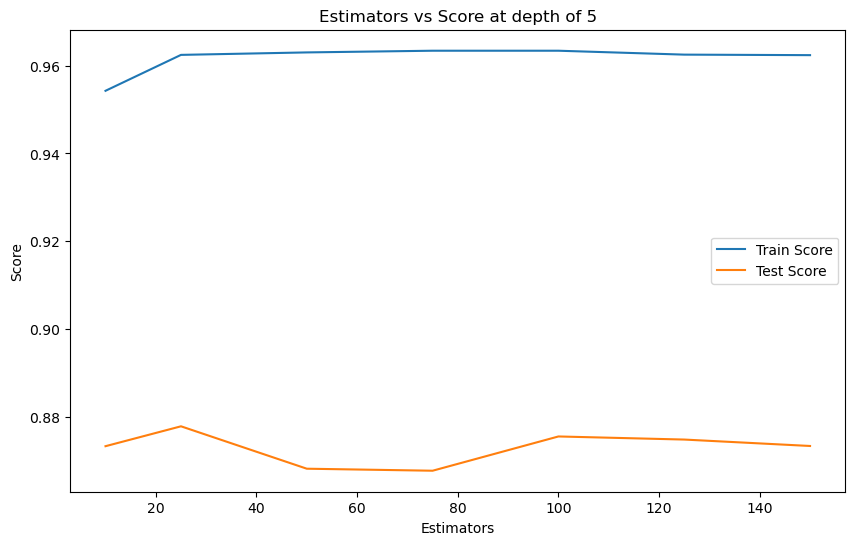

In [104]:
estimators = [10,25,50,75,100,125,150]
train_scores = []
test_scores = []

for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=5, max_features='auto', max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, min_samples_leaf=52, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=i, 
                                n_jobs=-1, random_state=25, verbose=0, warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    train_scores.append(train_sc)
    test_scores.append(test_sc)
    print(f"Estimators: {i} || Train F1 Score: {train_sc} || Test F1 Score: {test_sc}")

plt.figure(figsize=(10,6))
plt.plot(estimators, train_scores, label='Train Score')
plt.plot(estimators, test_scores, label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs Score at depth of 5')
plt.legend()
plt.show()


Depth: 2 || Train F1 Score: 0.941607810552555 || Test F1 Score: 0.8968885047536733
Depth: 3 || Train F1 Score: 0.9511297402692191 || Test F1 Score: 0.8871622814762492
Depth: 4 || Train F1 Score: 0.9621554532761029 || Test F1 Score: 0.8735189374426053
Depth: 5 || Train F1 Score: 0.9633662548039176 || Test F1 Score: 0.8755840729727917
Depth: 6 || Train F1 Score: 0.9643505903723888 || Test F1 Score: 0.8752823311045017
Depth: 7 || Train F1 Score: 0.969997433923531 || Test F1 Score: 0.8673271785633866
Depth: 8 || Train F1 Score: 0.9821127988805288 || Test F1 Score: 0.8842273321950462
Depth: 9 || Train F1 Score: 0.9905814946976932 || Test F1 Score: 0.8714682931204594


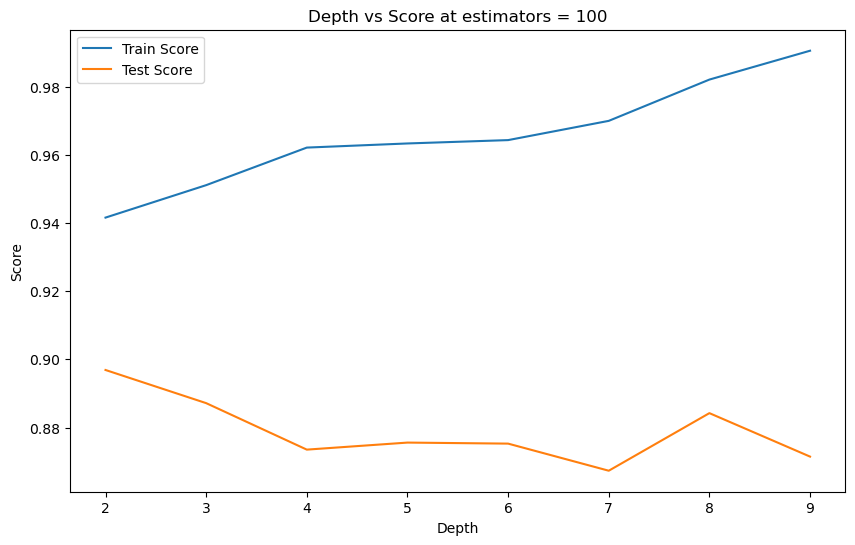

In [105]:
depths = [2,3,4,5,6,7,8,9]
train_scores = []
test_scores = []

for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=i, max_features='auto', max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, min_samples_leaf=52, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=100, 
                                n_jobs=-1, random_state=25, verbose=0, warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    train_scores.append(train_sc)
    test_scores.append(test_sc)
    print(f"Depth: {i} || Train F1 Score: {train_sc} || Test F1 Score: {test_sc}")

plt.figure(figsize=(10,6))
plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score at estimators = 100')
plt.legend()
plt.show()


In [106]:
# Hyperparameter Tuning
param_dict = {'n_estimators': sp_randint(80,120),
              'max_depth': sp_randint(3,7), 
              'min_samples_split': sp_randint(400,500), 
              'min_samples_leaf': sp_randint(400,500)}

rs = RandomizedSearchCV(RandomForestClassifier(random_state=25, n_jobs=-1), param_dict, n_iter=10, cv=5, scoring='f1', random_state=25)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002993046F450>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002993D2E1610>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029923764D50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000298FBD446D0>},
                   random_state=25, scoring='f1')

In [107]:
print("Mean test scores:", rs.cv_results_['mean_test_score'])


Mean test scores: [0.95318501 0.96033249 0.95069078 0.95211267 0.96068127 0.95390195
 0.96048744 0.95214163 0.96041117 0.96028318]


In [108]:
rs.best_estimator_


RandomForestClassifier(max_depth=6, min_samples_leaf=488, min_samples_split=455,
                       n_estimators=83, n_jobs=-1, random_state=25)

In [109]:
rs.best_score_

0.9606812736323864

In [110]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, min_samples_leaf=488, min_samples_split=455,
                       n_estimators=83, n_jobs=-1, random_state=25)

In [111]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


In [112]:
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))


Train F1 Score: 0.9610593996873157
Test F1 Score: 0.8574284416174466


## XGBoost Classifier

In [113]:
clf = XGBClassifier(colsample_bylevel=0.3, colsample_bytree=0.3, subsample=0.5, learning_rate=0.00001, 
                    max_depth=4, n_estimators=75, reg_lambda=10, n_jobs=-1)
clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1e-05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


In [115]:
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))


Train F1 Score: 0.668158299538526
Test F1 Score: 0.6692393676478415


In [116]:
# Hyperparameter tuning
param_dict = {'colsample_bylevel': [0.2,0.3], 'colsample_bytree': [0.2,0.3], 'subsample': [0.3,0.5], 'learning_rate':[0.00001, 0.000005], 
              'max_depth': [3,4], 'n_estimators': [50,75]}

rs = RandomizedSearchCV(XGBClassifier(n_jobs=-1), param_dict, n_iter=50, cv=5, scoring='f1', random_state=25)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bylevel': [0.2, 0.3],
                                        'colsample_bytree': [0.2, 0.3],
                                        'learning_rate': [1e-05, 5e-06],
                                        'max_depth': [3, 4],
                                        'n_estimators': [50, 75],
                                        'subsample': [0.3, 0.5]},
                   random_state=25, scoring='f1')

In [117]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.2, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=5e-06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [118]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


In [119]:
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))


Train F1 Score: 0.668158299538526
Test F1 Score: 0.6692393676478415


In [120]:
def plot_confusion_matrix(y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    labels = [0,1]
    
    cmap = sns.light_palette('blue')

    # Representing C in a heatmap format
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion Matrix')

    # Representing B in a heatmap format
    plt.subplot(1,3,2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Precision Matrix')

    # Representing A in a heatmap format
    plt.subplot(1,3,3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Recall Matrix')

    plt.show()
    

Train Confusion Matrix


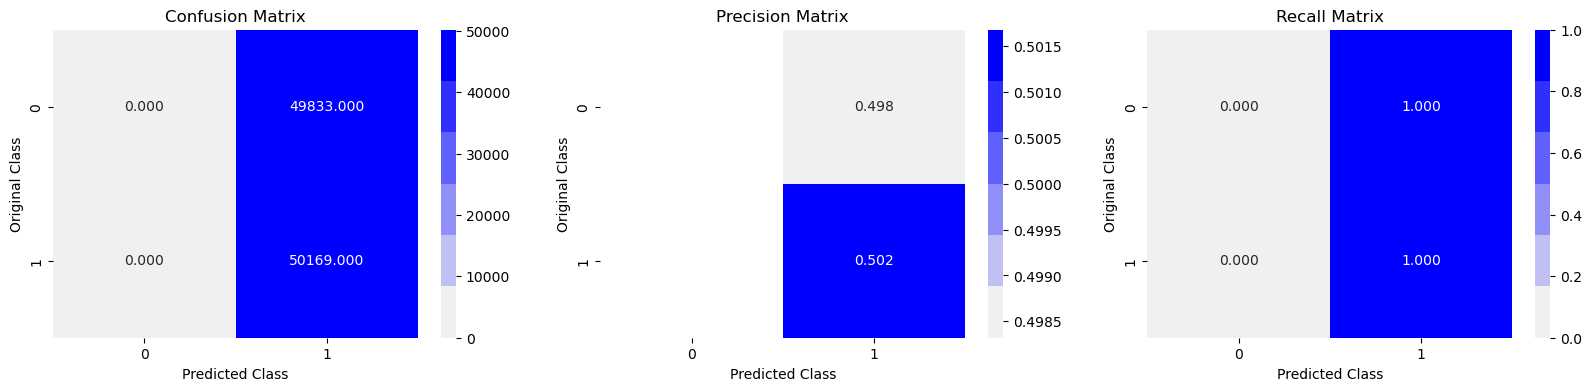

Test Confusion Matrix


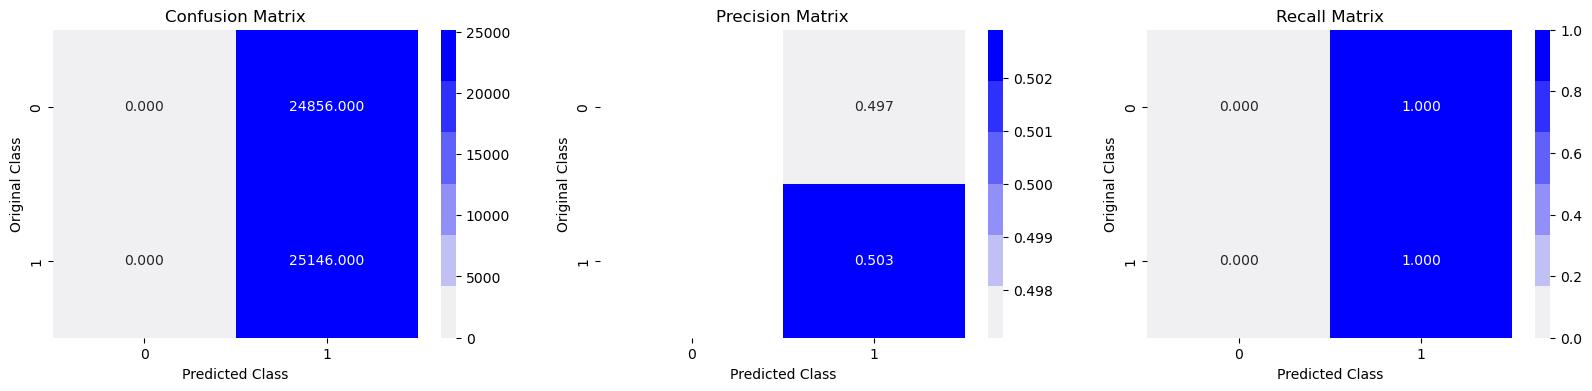

In [121]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train, y_train_pred)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred)


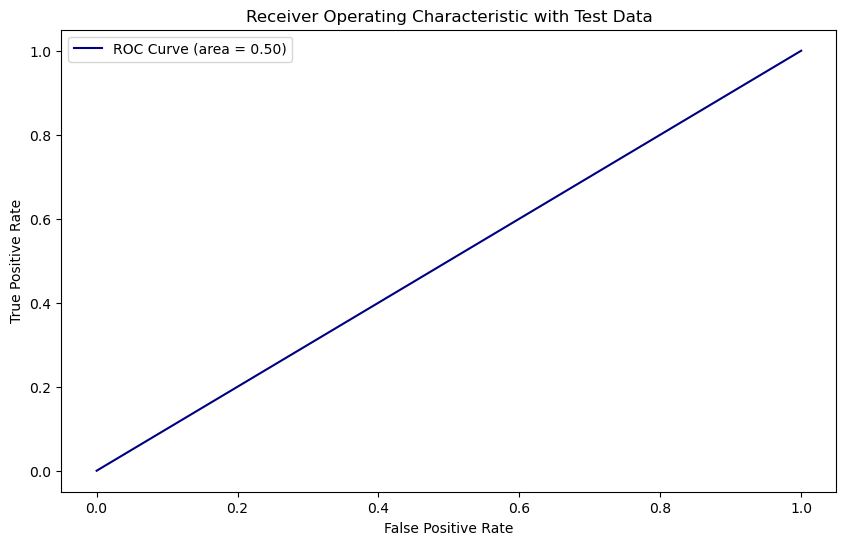

In [122]:
fpr,tpr,ths = roc_curve(y_test, y_test_pred)
auc_sc = auc(fpr,tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='navy', label='ROC Curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic with Test Data')
plt.legend()
plt.show()


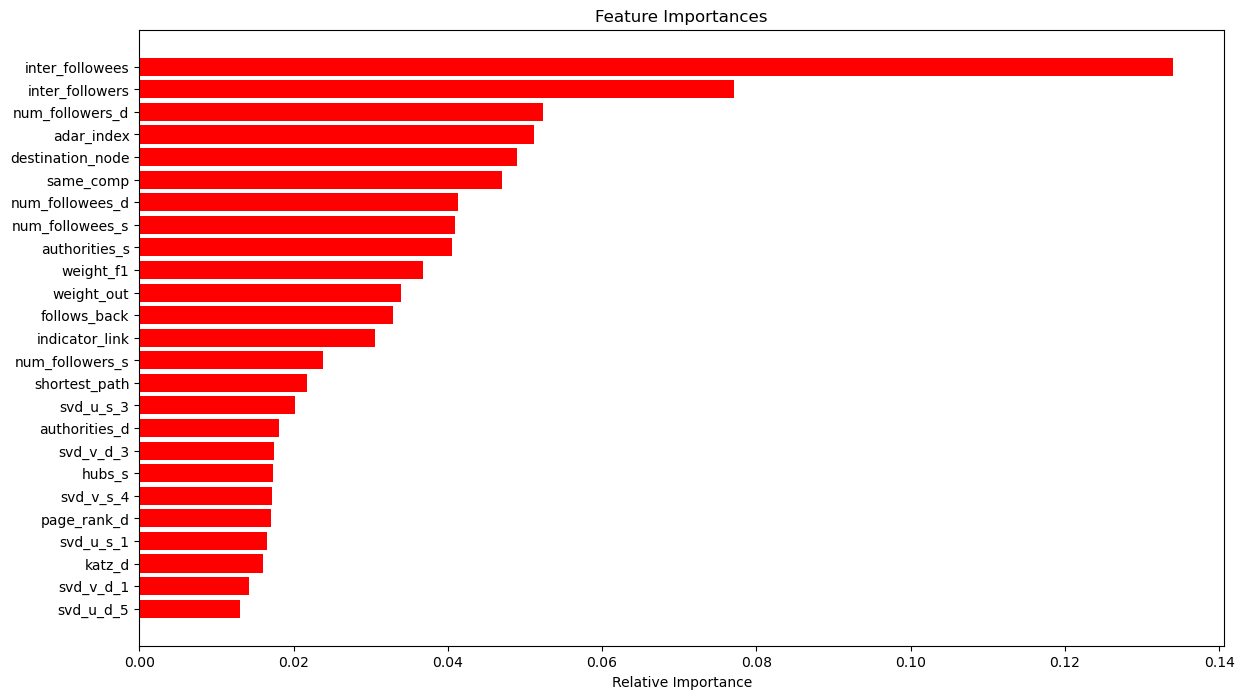

In [123]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(14,8))
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.title('Feature Importances')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
